OV-DINO
=====

**OV-DINO: Unified Open-Vocabulary Detection with Language-Aware Selective Fusion**

* Paper: https://arxiv.org/abs/2407.07844

![OV-DINO vs Previous Models](../assets/ovdino_vs_previous.jpg)

![OV-DINO's LASF](../assets/ovdino_lasf_overview.jpg)

![OV-DINO Overview](../assets/ovdino_overview.jpg)

## Installation

```bash
conda create -n ovdino python=3.10 -y
conda activate ovdino

# Install PyTorch for CUDA 11.6 from the official channels
conda install -y pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 \
                pytorch-cuda=11.6 -c pytorch -c nvidia

# Optional: install GCC 9 for compatibility when compiling detectron2
conda install -y gcc=9 gxx=9 -c conda-forge

# install cudatoolkit-11.6
conda install -y cudatoolkit-dev=11.6 -c conda-forge

# set CUDA_HOME env-var:
export CUDA_HOME=$CONDA_PREFIX  # since cudatoolkit-dev installs CUDA here
export PATH=$CUDA_HOME/bin:$PATH
export LD_LIBRARY_PATH=$CUDA_HOME/lib:$LD_LIBRARY_PATH

# Verify nvcc version
nvcc -V
# It should report "Cuda compilation tools, release 11.6".
```
 
```bash
git clone https://github.com/wanghao9610/OV-DINO.git OVDINO_repo
cd OVDINO_repo
export root_dir=$(realpath ./)
cd $root_dir/ovdino

# build and install detectron2
python -m pip install -e detectron2-717ab9
# If this step fails with this error: 
# ImportError: /opt/conda/envs/ovdinov2/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so: undefined symbol: iJIT_NotifyEvent
# This error is related to MKL verison mismatch, run the following 
# conda list | egrep 'mkl|tbb|itt|openmp'
# Force MKL back to 2024.0.0 (the last version without the iJIT requirement)
# conda install -y -c conda-forge "mkl=2024.0.0" "mkl-devel=2024.0.0" "mkl-include=2024.0.0"


pip install addict

# install OV-DINO itself
pip install -e .
```


 * Later warning about numpy version
 ```
 pip install "numpy<2"
 ```

## Download model

```bash
wget https://huggingface.co/hao9610/OV-DINO/resolve/main/ovdino_swint_ogc-coco50.2_lvismv40.1_lvis32.9.pth  -P OVDINO_repo/inits/
```

In [1]:
import numpy as np
np.__version__

'1.26.4'

In [2]:
import os
import cv2
import torch
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detrex.data.datasets import clean_words_or_phrase

def filter_predictions_with_confidence(predictions, threshold=0.5):
    """
    Keep only instances above a given confidence threshold.
    """
    if "instances" in predictions:
        preds = predictions["instances"]
        keep_idxs = preds.scores > threshold
        predictions = predictions.copy()  # avoid modifying in place
        predictions["instances"] = preds[keep_idxs]
    return predictions

# ---------------------------------------------------------------------
# 1. Load config and build model
# ---------------------------------------------------------------------
# Ensure MODEL_ROOT points to the directory containing your checkpoints
os.environ["MODEL_ROOT"] = "./inits"
cfg = LazyConfig.load(
    "OVDINO_repo/ovdino/projects/ovdino/configs/ovdino_swin_tiny224_bert_base_eval_coco.py"
)
# Override with the full OV‑DINO checkpoint you downloaded
cfg.train.init_checkpoint = (
    "OVDINO_repo/inits/ovdino/ovdino_swint_ogc-coco50.2_lvismv40.1_lvis32.9.pth"
)

model = instantiate(cfg.model)
model.to(cfg.train.device)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.train.init_checkpoint)
model.eval();


/home/pyml/anaconda3/envs/ovdino/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pyml/anaconda3/envs/ovdino/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/pyml/anaconda3/envs/ovdino/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/pyml/anaconda3/envs/ovdino/lib/python3.10/site-pack

In [3]:
# ---------------------------------------------------------------------
# 2. Prepare category names (open vocabulary)
# ---------------------------------------------------------------------
raw_categories = ["plant", "vase"]
category_names = [clean_words_or_phrase(c) for c in raw_categories]

# ---------------------------------------------------------------------
# 3. Read and preprocess the image
# ---------------------------------------------------------------------
image_path = "../samples/plants.jpg"
# Load BGR image using OpenCV
bgr_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if bgr_image is None:
    raise FileNotFoundError(f"Unable to read image: {image_path}")

# The model expects an RGB image; convert if necessary
if cfg.model.input_format == "RGB":
    rgb_image = bgr_image[:, :, ::-1]
else:
    rgb_image = bgr_image

# Record the original dimensions before resizing
height, width = rgb_image.shape[:2]

# Apply the same resizing used by the demo (shortest edge=800, max size=1333)
resizer = T.ResizeShortestEdge([800, 800], 1333)
resized_image = resizer.get_transform(rgb_image).apply_image(rgb_image)

# Convert to CHW tensor (float32) as expected by detectron2
tensor_image = torch.Tensor(resized_image.astype("float32").transpose(2, 0, 1))

# ---------------------------------------------------------------------
# 4. Build the input dict and run inference
# ---------------------------------------------------------------------
inputs = {
    "image": tensor_image,
    "height": height,
    "width": width,
    "category_names": category_names,
}

with torch.no_grad():
    predictions = model([inputs])[0]
    # Filter by confidence if desired
    predictions = filter_predictions_with_confidence(predictions, threshold=0.5)

# ---------------------------------------------------------------------
# 5. Inspect the results
# ---------------------------------------------------------------------
if "instances" in predictions:
    instances = predictions["instances"].to(torch.device("cpu"))
    for i in range(len(instances)):
        bbox = instances.pred_boxes.tensor[i].tolist()  # [x1,y1,x2,y2]
        score = instances.scores[i].item()
        # pred_classes corresponds to index in category_names
        class_idx = instances.pred_classes[i].item()
        class_name = category_names[class_idx] if class_idx < len(category_names) else str(class_idx)
        print(f"{class_name}: score={score:.3f}, box={bbox}")
else:
    print("No instances detected.")


plant: score=0.567, box=[429.24652099609375, 76.37261962890625, 790.2409057617188, 796.6929321289062]
plant: score=0.532, box=[131.57545471191406, 480.75732421875, 464.2589416503906, 900.4660034179688]
vase: score=0.517, box=[462.1734924316406, 497.2107238769531, 786.7843017578125, 1088.8697509765625]


In [4]:
predictions

{'instances': Instances(num_instances=3, image_height=1137, image_width=1068, fields=[pred_boxes: Boxes(tensor([[ 429.2465,   76.3726,  790.2409,  796.6929],
         [ 131.5755,  480.7573,  464.2589,  900.4660],
         [ 462.1735,  497.2107,  786.7843, 1088.8698]], device='cuda:0')), scores: tensor([0.5674, 0.5317, 0.5174], device='cuda:0'), pred_classes: tensor([0, 0, 1], device='cuda:0')])}

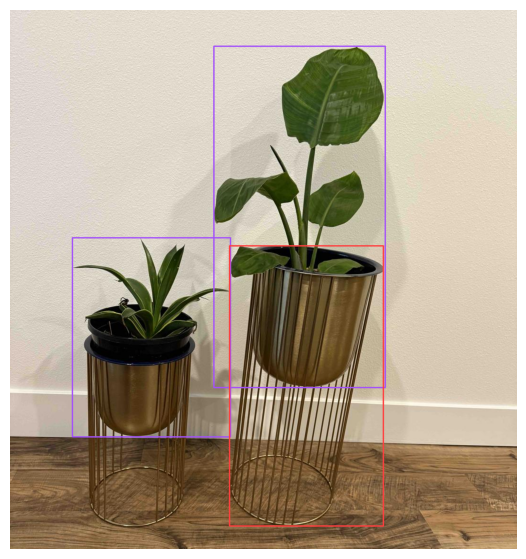

In [5]:
# visualizer the prefictions with supervision

import supervision as sv
import matplotlib.pyplot as plt

detections = sv.Detections.from_detectron2(predictions)
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.8)
annotated_image = box_annotator.annotate(
    scene=bgr_image, 
    detections=detections
)

plt.figure(figsize=(7, 7), dpi=100)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()